In [1]:
%matplotlib inline

In [2]:
from __future__ import division          # use // for integer division
from __future__ import absolute_import   # use from . import
from __future__ import print_function    # use print("...") instead of print "..."
from __future__ import unicode_literals  # all the strings are unicode

# Covariance Matrix Adaptation

連続最適化の困難さの一つに悪スケール性 (ill-conditioning) が挙げられる．悪スケール性とは，変数毎に目的関数へ与える影響が大きく異なる性質をさす．これは，関数のヘッセ行列(二回微分して得られる行列)の最大固有値と最小固有値の比率 (これを条件数 Condition Number と呼ぶ) が大きいことに対応する．

今回は，以下の点について確認する．

* 悪スケール性を有する関数を最適化する場合，ステップサイズを適応するだけでは効率が悪いこと
* 探索分布 (正規分布) の共分散行列を適応 (形を適応) する Covariance Matrix Adaptation によって，効率を改善できること

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### CSA-ES

In [4]:
class CSAES(object):
    """CSA Evolution Strategy"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.cs = 4.0 / (self.N + 4.0)
        self.ds = 1.0 + self.cs
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        self.mueff = 1.0 / np.sum(self.weights**2)
        
    def sample(self):
        """候補解を生成する．"""
        self.arx = self.mean + self.sigma * np.random.normal(size=self.arx.shape)
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_mean(self):
        """平均ベクトルを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        self.mean += np.dot(self.weights, (self.arx[idx] - self.mean))
        
    def update_sigma(self):
        """CSA"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, (self.arx[idx] - self.mean)) / self.sigma
        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))

#### Ellipsoid関数と条件数

In [5]:
EllipsoidCondition = 1
def ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    return np.sqrt(np.sum(w * x ** 2))

等高線をプロットする．条件数を0, 1, 2,...と変えて確認する．

(-1.0, 1.0, -1.0, 1.0)

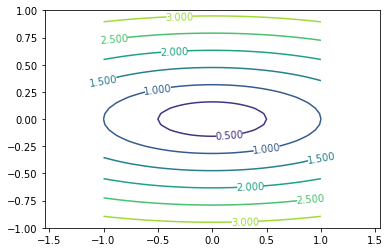

In [6]:
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-1, 1 + dy, dy), slice(-1, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = ellipsoid(np.array([x[i,j], y[i,j]]))
        
plt.figure()
CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)
plt.axis('equal')

#### CSA-ESによる実験

EllipsoidCondition = 6 と定義してから以下を実行する．

In [7]:
es = CSAES(func=ellipsoid,            
           init_mean=np.ones(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 2000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_sigma()
    es.update_mean()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N

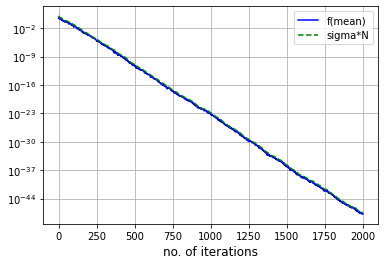

In [8]:
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend()

In [9]:
#### 条件数を変化させた場合の収束曲線の変化

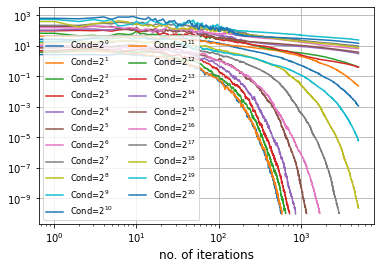

In [10]:
EllCondArray = np.linspace(0, 20, num=21, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    
    def ellipsoid(x):
        """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
        w = np.logspace(0, EllipsoidCondition, base=2, num=x.shape[0], endpoint=True)
        return np.sqrt(np.sum(w * x ** 2))

    es = CSAES(func=ellipsoid,            
               init_mean=np.zeros(20),  
               init_sigma=1, 
               nsample=10)             

    maxiter = 5000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_sigma()
        es.update_mean()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
        if mean[i] < 1e-10:
            break
    
    plt.loglog(mean, label=r'Cond=$2^{'+str(j)+'}$')

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)


条件数が高くなると，目的関数のlog-scaleでの傾きが緩やかになる．最適化に時間がかかる．

* 生成される解の分布と等高線の関係に注意して考察すること

#### 共分散行列の適応 (Covariance Matrix Adaptation)

アイディア: 解生成分布の共分散行列を適応し，座標毎に探索する幅を変え，解生成分布を関数の等高線の形状に近づける．

In [11]:
class CMAES(object):
    """CMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        self.D = np.ones(self.N)
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.cs = 4.0 / (self.N + 4.0)
        self.ds = 1.0 + self.cs
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        self.mueff = 1.0 / np.sum(self.weights**2)
        
        # For CMA
        self.cmu = self.mueff / (4 * self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arx = self.mean + self.sigma * np.random.normal(size=self.arx.shape) * np.sqrt(self.D)
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, (self.arx[idx] - self.mean)) / np.sqrt(self.D) / self.sigma
        
        # 共分散行列の対角要素を更新
        self.D = (1 - self.cmu) * self.D + self.cmu * np.dot(self.weights, (self.arx[idx] - self.mean) ** 2) / self.sigma ** 2
        
        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, (self.arx[idx] - self.mean))

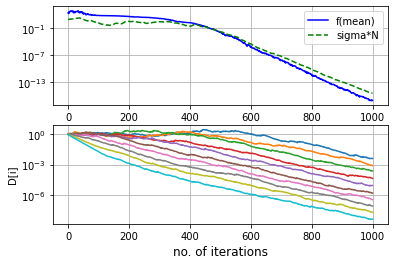

In [12]:
EllipsoidCondition = 6
def ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    return np.sqrt(np.sum(w * x ** 2))

es = CMAES(func=ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    diagC[i] = es.D
    
plt.subplot(211)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(212)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()


#### 条件数を変化させた場合の比較

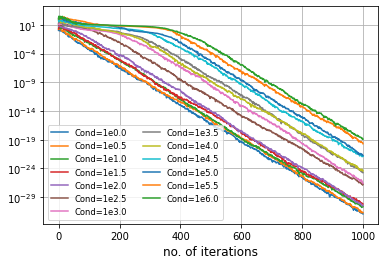

In [13]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    
    def ellipsoid(x):
        """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
        w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
        return np.sqrt(np.sum(w * x ** 2))

    es = CMAES(func=ellipsoid,            
               init_mean=np.zeros(10),  
               init_sigma=1, 
               nsample=10)             

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)

条件数が大きいと

* 探索序盤に，共分散行列を学習するための時間がかかる
* 共分散行列学習後は収束曲線の傾きが条件数によらずほとんど一定

## 考察

* 学習後の共分散行列と目的関数の関係を調べよ
* どのような原理で共分散行列の形状が適応されていくのか，考察せよ